# Filter Data

Add the "Fall" column and set it to True if there was a fall and False if there wasn't.

In [ ]:
import pandas as pd

nameDfFall = "dataFall.csv"
nameDfNoFall = "dataNoFall.csv"

dfFall = pd.read_csv(nameDfFall)
dfNoFall = pd.read_csv(nameDfNoFall)

#Adicionar a coluna ue diz se é queda
dfFall['Fall'] = True
dfNoFall['Fall'] = False

#remover coluna time pois ela não é necessaria
dfFall = dfFall.drop('Time(ms)', axis=1)
dfNoFall = dfNoFall.drop('Time(ms)', axis=1)


#Salvar dados novos
dfFall.to_csv('NewDataFall.csv', index=False)
dfNoFall.to_csv('NewDataNoFall.csv', index=False)


I'll combine lines 20 at a time, because the decline is a process. We have a sudden variation at the beginning of the decline and one at the end.
If we consider just one line of data, there will be many gaps.

In [7]:
import pandas as pd

def agrupar_janelas(df, window_size=20):
    colunas_sem_fall = df.columns.drop("Fall")
    janelas = []

    for i in range(0, len(df) - window_size + 1):
        janela = df.iloc[i:i + window_size]
        linha = {}

        for j in range(window_size):
            for col in colunas_sem_fall:
                linha[f"{col}_{j}"] = janela.iloc[j][col]

        # Pode usar o valor mais frequente da janela, ou o último
        linha["Fall"] = int(janela["Fall"].mode()[0])  # ou janela["Fall"].iloc[-1]
        janelas.append(linha)

    return pd.DataFrame(janelas)


# Carregar os arquivos
df_fall = pd.read_csv("NewDataFall.csv")
df_nofall = pd.read_csv("NewDataNoFall.csv")

# Agrupar de 20 em 20 separadamente
df_fall_windowed = agrupar_janelas(df_fall, window_size=20)
df_nofall_windowed = agrupar_janelas(df_nofall, window_size=20)

# Concatenar os dois conjuntos
df_final = pd.concat([df_fall_windowed, df_nofall_windowed], ignore_index=True)

# Embaralha
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Salvar o resultado
df_final.to_csv("Dataset_Falls_Grouped_20.csv", index=False)

print("✅ Dataset com janelas agrupadas criado com sucesso!")


✅ Dataset com janelas agrupadas criado com sucesso!


# Criar arvore de decisão

✅ Acurácia no conjunto de teste: 100.00%


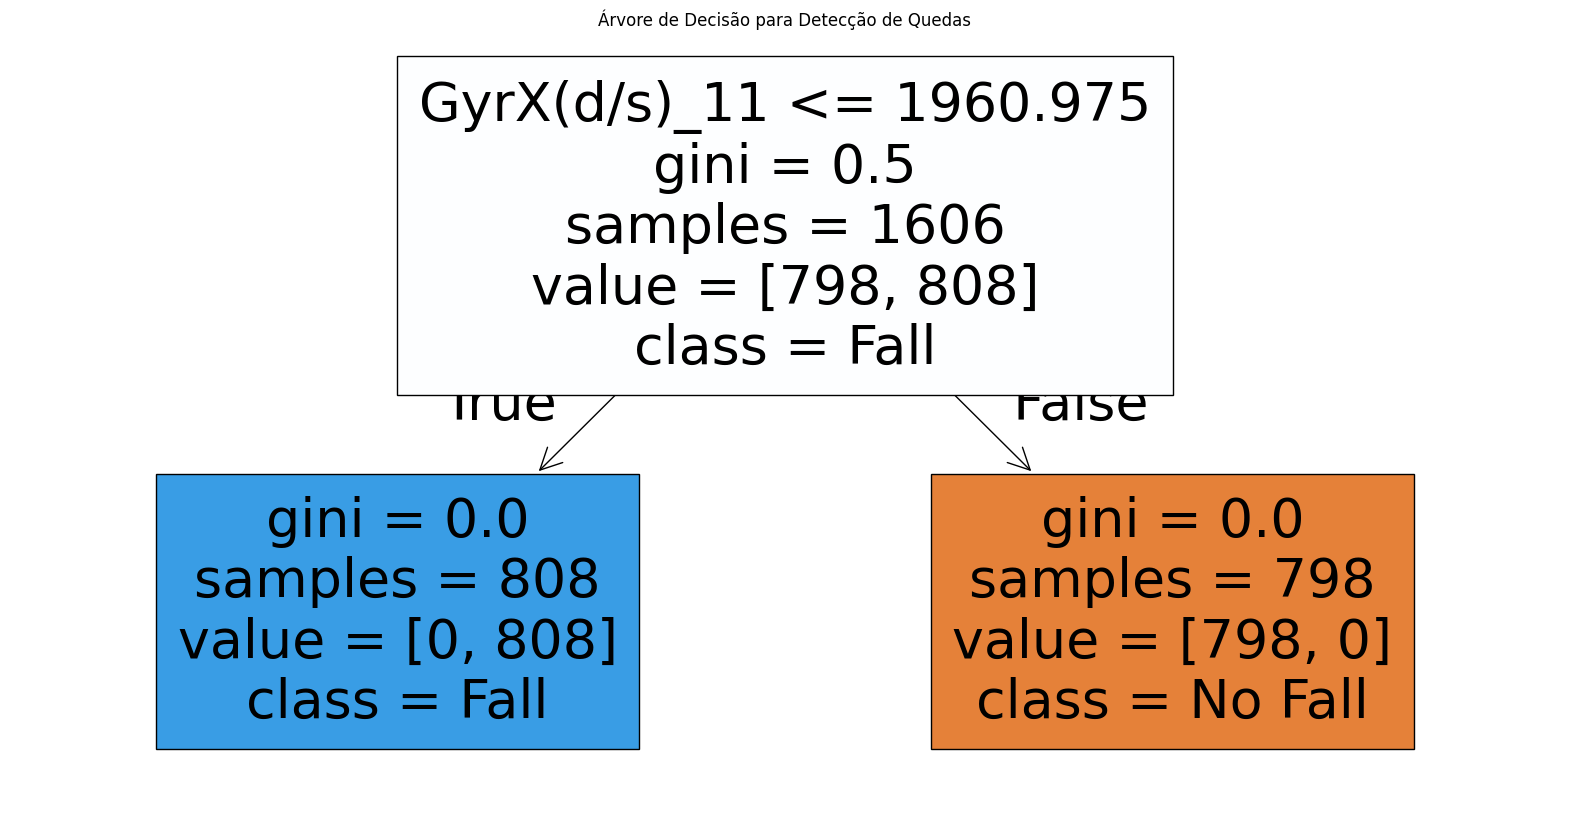

|--- GyrX(d/s)_11 <= 1960.98
|   |--- class: 1
|--- GyrX(d/s)_11 >  1960.98
|   |--- class: 0



In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import export_text

# 1. Carregar o dataset
df = pd.read_csv("Dataset_Falls_Grouped_20.csv")

# 2. Separar em features (X) e alvo (y)
X = df.drop("Fall", axis=1)
y = df["Fall"]

# 3. Separar em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Treinar a árvore de decisão
clf = DecisionTreeClassifier(max_depth=4, random_state=42)  # Árvore simples com profundidade máxima 4
clf.fit(X_train, y_train)

# 5. Avaliar acurácia
accuracy = clf.score(X_test, y_test)
print(f"✅ Acurácia no conjunto de teste: {accuracy:.2%}")

# 6. Plotar a árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=["No Fall", "Fall"], filled=True)
plt.title("Árvore de Decisão para Detecção de Quedas")
plt.show()


# Gerar representação textual da árvore
tree_text = export_text(clf, feature_names=list(X.columns))
print(tree_text)

✅ Dataset com janelas agrupadas criado com sucesso!
✅ Acurácia no conjunto de teste: 100.00%


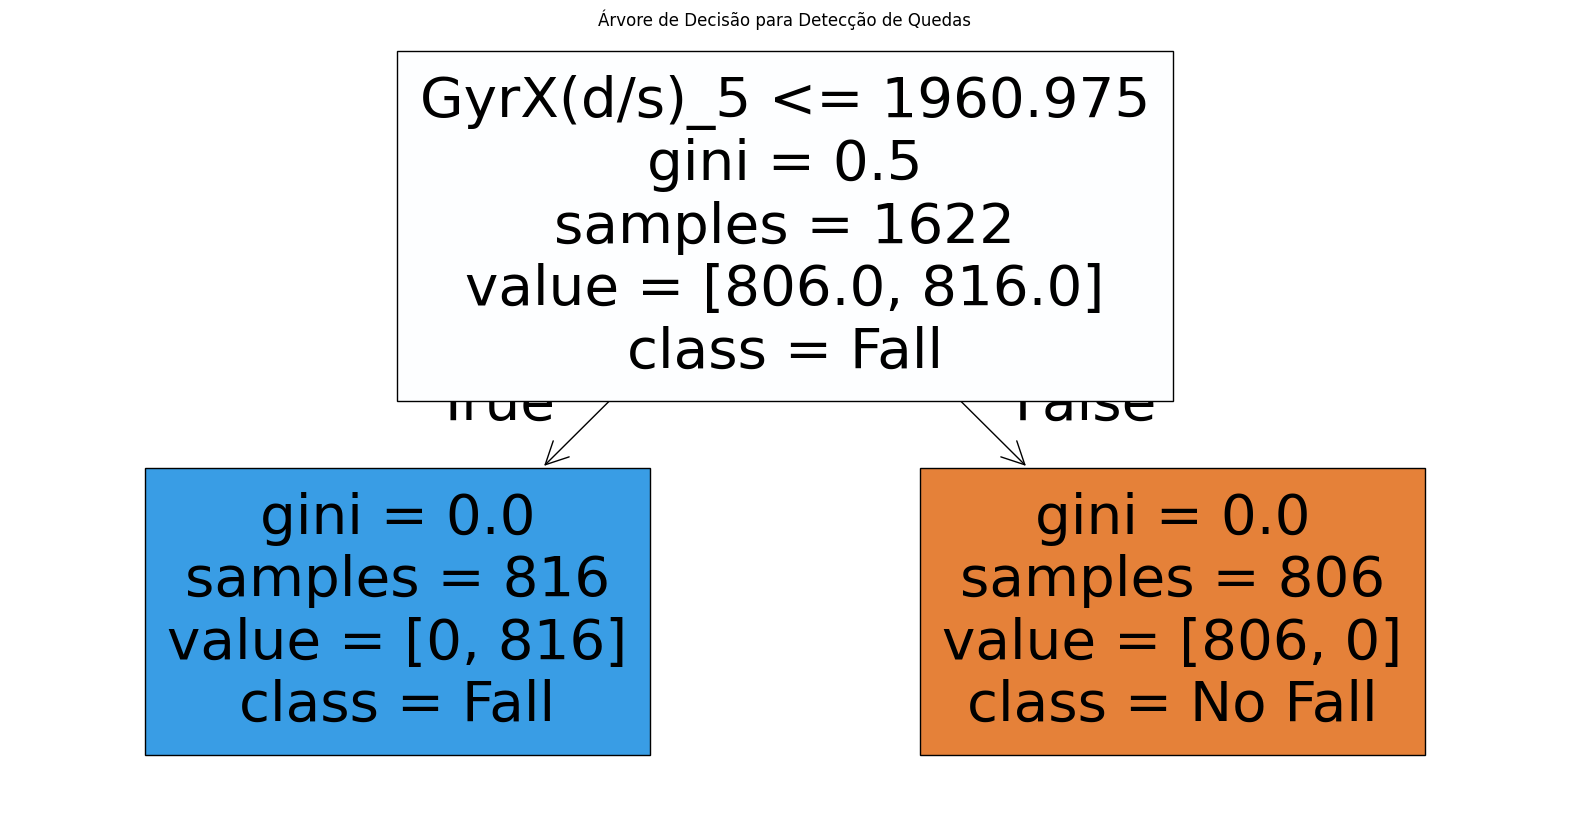

|--- GyrX(d/s)_5 <= 1960.98
|   |--- class: 1
|--- GyrX(d/s)_5 >  1960.98
|   |--- class: 0



In [11]:
#Testar com outros tamanhos de janela

#TESTAR JANELA == 10
# Carregar os arquivos já processados
df_fall = pd.read_csv("NewDataFall.csv")
df_nofall = pd.read_csv("NewDataNoFall.csv")

# Agrupar de 10 em 10 separadamente
df_fall_windowed = agrupar_janelas(df_fall, window_size=10)
df_nofall_windowed = agrupar_janelas(df_nofall, window_size=10)

# Concatenar os dois conjuntos
df_final = pd.concat([df_fall_windowed, df_nofall_windowed], ignore_index=True)

# Embaralha
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Salvar o resultado
df_final.to_csv("Dataset_Falls_Grouped_10.csv", index=False)

print("✅ Dataset com janelas agrupadas criado com sucesso!")


#CRIAR ARVORE

# 1. Carregar o dataset
df = pd.read_csv("Dataset_Falls_Grouped_10.csv")

# 2. Separar em features (X) e alvo (y)
X = df.drop("Fall", axis=1)
y = df["Fall"]

# 3. Separar em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Treinar a árvore de decisão
clf = DecisionTreeClassifier(max_depth=4, random_state=42)  # Árvore simples com profundidade máxima 4
clf.fit(X_train, y_train)

# 5. Avaliar acurácia
accuracy = clf.score(X_test, y_test)
print(f"✅ Acurácia no conjunto de teste: {accuracy:.2%}")

# 6. Plotar a árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=["No Fall", "Fall"], filled=True)
plt.title("Árvore de Decisão para Detecção de Quedas")
plt.show()

# Gerar representação textual da árvore
tree_text = export_text(clf, feature_names=list(X.columns))
print(tree_text)

✅ Dataset com janelas agrupadas criado com sucesso!
✅ Acurácia no conjunto de teste: 100.00%


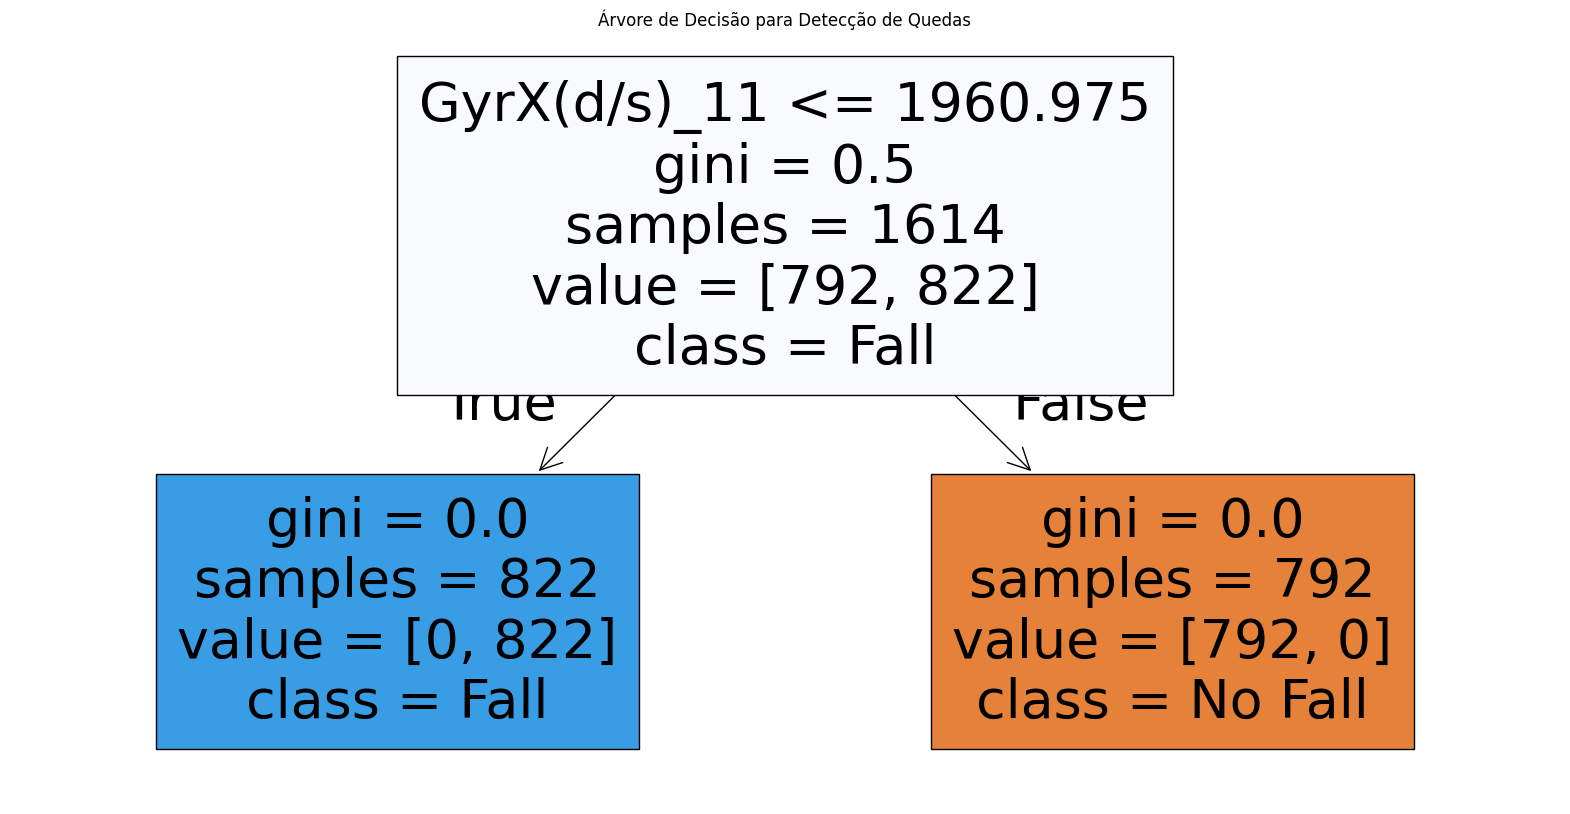

|--- GyrX(d/s)_11 <= 1960.98
|   |--- class: 1
|--- GyrX(d/s)_11 >  1960.98
|   |--- class: 0



In [12]:
#Testar com outros tamanhos de janela
windowSize = 15
#TESTAR JANELA == 15
# Carregar os arquivos já processados
df_fall = pd.read_csv("NewDataFall.csv")
df_nofall = pd.read_csv("NewDataNoFall.csv")

# Agrupar de 15 em 15 separadamente
df_fall_windowed = agrupar_janelas(df_fall,window_size=windowSize)
df_nofall_windowed = agrupar_janelas(df_nofall, window_size=windowSize)

# Concatenar os dois conjuntos
df_final = pd.concat([df_fall_windowed, df_nofall_windowed], ignore_index=True)

# Embaralha
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Salvar o resultado
df_final.to_csv("Dataset_Falls_Grouped_15.csv", index=False)

print("✅ Dataset com janelas agrupadas criado com sucesso!")


#CRIAR ARVORE

# 1. Carregar o dataset
df = pd.read_csv("Dataset_Falls_Grouped_15.csv")

# 2. Separar em features (X) e alvo (y)
X = df.drop("Fall", axis=1)
y = df["Fall"]

# 3. Separar em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Treinar a árvore de decisão
clf = DecisionTreeClassifier(max_depth=4, random_state=42)  # Árvore simples com profundidade máxima 4
clf.fit(X_train, y_train)

# 5. Avaliar acurácia
accuracy = clf.score(X_test, y_test)
print(f"✅ Acurácia no conjunto de teste: {accuracy:.2%}")

# 6. Plotar a árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=["No Fall", "Fall"], filled=True)
plt.title("Árvore de Decisão para Detecção de Quedas")
plt.show()

# Gerar representação textual da árvore
tree_text = export_text(clf, feature_names=list(X.columns))
print(tree_text)